dependencies


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
#from IPython.display import HTML

all constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
#CHANNELS=3
#EPOCHS=50

Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)
#68 it's the number of batchs , so 68 * 32 (batch_size = number of images) = 2176


68

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
#print(labels_batch.numpy()) show [0 0 0 0 1 0 0 1 0 0 2 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1] : 
# 0 , 1, 2 : ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'] for 32 images in the batch


(32, 256, 256, 3)
[0 0 0 0 1 0 0 1 0 0 2 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1]


2025-11-12 16:29:26.585368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Visualize some of the images from our dataset

2025-11-12 16:37:44.604272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


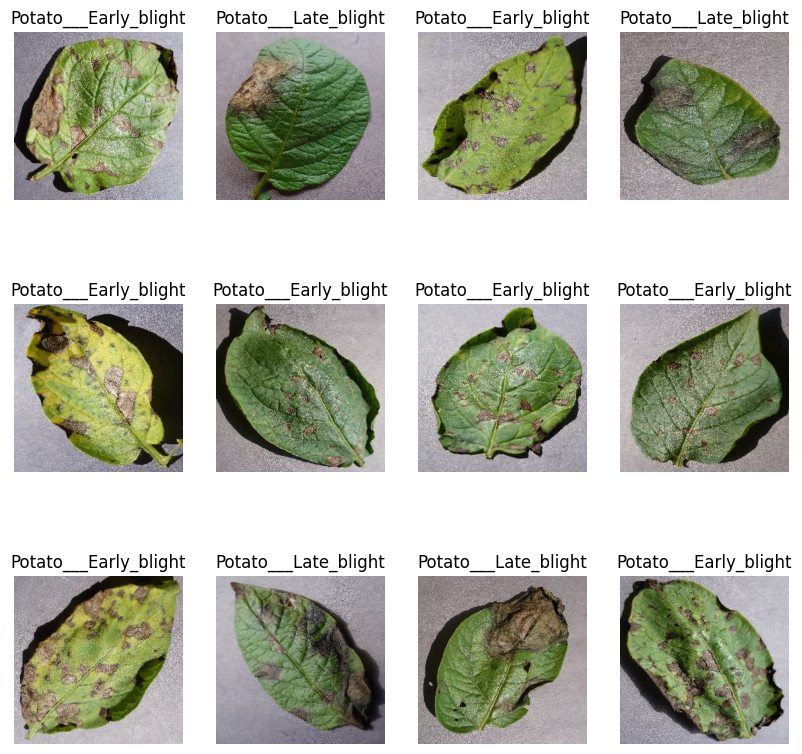

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

data split

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    print("ds_size",ds_size)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    print("train_size",train_size)
    #80% so train_size= 54
    val_size = int(val_split * ds_size)
    #10% so train_size= 6
    print("val_size",val_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    #take the rest , which is 8
    test_ds = ds.skip(train_size).skip(val_size)
    print("train_ds: ",len(train_ds), " val_ds: ",len(val_ds)," test_ds: ",len(test_ds))
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

ds_size 68
train_size 54
val_size 6
train_ds:  54  val_ds:  6  test_ds:  8


improve the performance of training

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

building model

Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [22]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

Data augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [25]:
#apply data augmentation to train dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)